(128, 128)
(128, 128)
Matrix A at (50, 50):
[[0.00257884 0.00257884]
 [0.00257884 0.00257884]]
Vector b at (50, 50):
[-0.0006577 -0.0006577]
Matrix A at (50, 100):
[[0.00043259 0.00043259]
 [0.00043259 0.00043259]]
Vector b at (50, 100):
[-0.02217288 -0.02217288]
Matrix A at (100, 50):
[[0.00218509 0.00218509]
 [0.00218509 0.00218509]]
Vector b at (100, 50):
[0.01305953 0.01305953]
Matrix A at (100, 100):
[[0.00449201 0.00449201]
 [0.00449201 0.00449201]]
Vector b at (100, 100):
[0.00130049 0.00130049]
max flow: 372.4509 flow range: u = -263.363 .. 120.757; v = -263.363 .. 120.757



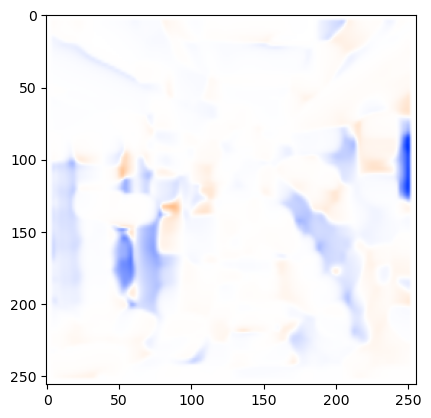

(100, 100)
(100, 100)
Matrix A at (50, 50):
[[0.00397082 0.00397082]
 [0.00397082 0.00397082]]
Vector b at (50, 50):
[-0.000855 -0.000855]
max flow: 6.2192 flow range: u = -4.398 .. 4.328; v = -4.398 .. 4.328



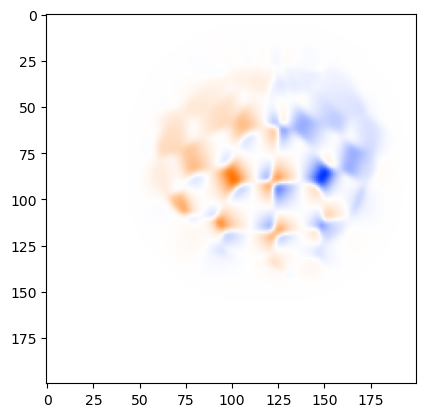

(64, 64)
(64, 64)
Matrix A at (50, 50):
[[0.00338661 0.00338661]
 [0.00338661 0.00338661]]
Vector b at (50, 50):
[0.00266424 0.00266424]
max flow: 1.4091 flow range: u = -0.343 .. 0.996; v = -0.343 .. 0.996



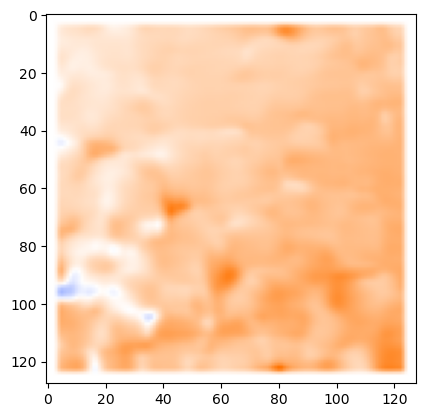

200
200
(200, 200)
(200, 200)
(40000, 2)
(200, 200)


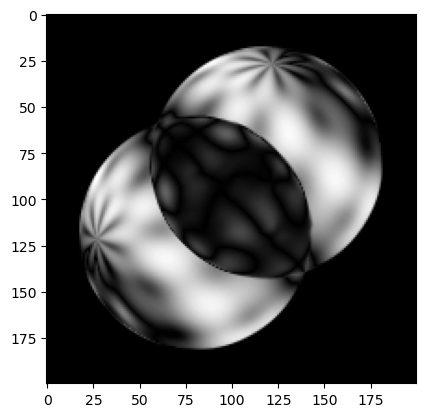

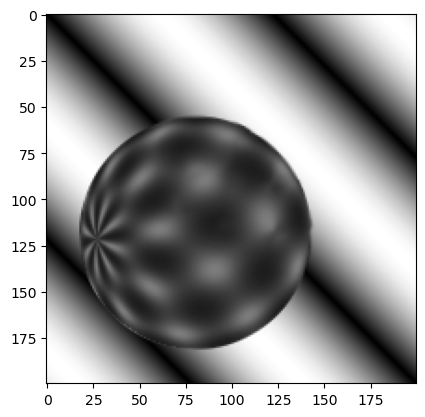

In [135]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import RegularGridInterpolator
import time

bt0 = cv2.imread('bt_0.png')
bt1 = cv2.imread('bt_1.png')
sphere0 = cv2.imread('sphere_0.png')
sphere1 = cv2.imread('sphere_1.png')
synth0 = cv2.imread('synth_0.png')
synth1 = cv2.imread('synth_1.png')

#normalize the intensities
bt0 = cv2.cvtColor(bt0, cv2.COLOR_BGR2GRAY) / 255.0
bt1 = cv2.cvtColor(bt1, cv2.COLOR_BGR2GRAY) / 255.0
sphere0 = cv2.cvtColor(sphere0, cv2.COLOR_BGR2GRAY) / 255.0
sphere1 = cv2.cvtColor(sphere1, cv2.COLOR_BGR2GRAY) / 255.0
synth0 = cv2.cvtColor(synth0, cv2.COLOR_BGR2GRAY) / 255.0
synth1 = cv2.cvtColor(synth1, cv2.COLOR_BGR2GRAY) / 255.0

def flowToColor(flow, maxflow=None, verbose=False):
    '''
    args
        flow (numpy array) height x width x 2
    return
        img_color (numpy array) height x width x 3
    '''

    UNKNOWN_FLOW_THRESH = 5e2
    eps = 1e-6

    height, widht, nBands = flow.shape

    if nBands != 2:
        exit('flowToColor: image must have two bands')

    u = flow[:, :, 0]
    v = flow[:, :, 1]

    maxu = -999
    maxv = -999

    minu = 999
    minv = 999
    maxrad = -1

    # fix unknown flow
    idxUnknown = (abs(u) > UNKNOWN_FLOW_THRESH) | (abs(v) > UNKNOWN_FLOW_THRESH)
    u[idxUnknown] = 0
    v[idxUnknown] = 0

    maxu = max(maxu, u.max())
    minu = min(minu, u.min())

    maxv = max(maxv, v.max())
    minv = min(minv, v.min())

    rad = np.sqrt(u ** 2 + v ** 2)
    maxrad = max(maxrad, rad.max())

    if verbose:
        print('max flow: %.4f flow range: u = %.3f .. %.3f; v = %.3f .. %.3f\n' %
              (maxrad, minu, maxu, minv, maxv))

    if maxflow is not None:
        if maxflow > 0:
            maxrad = maxflow

    u = u / (maxrad + eps)
    v = v / (maxrad + eps)

    img = computeColor(u, v)

    # unknown flow
    # IDX = repmat(idxUnknown, [1, 1, 3])
    img[idxUnknown] = 0

    return img

def computeColor(u, v, cast_uint8=True):
    '''
    args
        u (numpy array) height x width
        v (numpy array) height x width
        cast_uint8 (bool) set False to have image range 0-1 (np.float32)
    return
        img_color (numpy array) height x width x 3
    '''

    nanIdx = np.isnan(u) | np.isnan(v)
    u[nanIdx] = 0
    v[nanIdx] = 0

    colorwheel = makeColorwheel()
    ncols = colorwheel.shape[0]

    rad = np.sqrt(u ** 2 + v ** 2)

    a = np.arctan2(-v, -u)/np.pi

    fk = (a + 1) / 2 * (ncols - 1)  # -1~1 maped to 1~ncols

    k0 = np.floor(fk).astype(int)  # 1, 2, ..., ncols

    k1 = k0 + 1
    k1[k1 == ncols + 1] = 1

    f = fk - k0

    height, width = u.shape
    img = np.zeros((height, width, 3), np.float32)
    nrows = colorwheel.shape[1]
    for i in range(nrows):
        tmp = colorwheel[:, i]
        col0 = tmp[k0.reshape(-1)] / 255
        col1 = tmp[k1.reshape(-1)] / 255
        col = col0.reshape(height, width) * (1 - f) + \
              col1.reshape(height, width) * f

        idx = rad <= 1
        col[idx] = 1 - rad[idx] * (1 - col[idx])  # increase saturation with radius

        col[np.logical_not(idx)] *= 0.75  # out of range

        img[:, :, i] = col * (1 - nanIdx)

    if cast_uint8:
        img = np.floor(img * 255).astype(np.uint8)
    return img


def makeColorwheel():
    '''
    color encoding scheme
    adapted from the color circle idea described at
    http://members.shaw.ca/quadibloc/other/colint.htm
    '''

    RY = 15
    YG = 6
    GC = 4
    CB = 11
    BM = 13
    MR = 6

    ncols = RY + YG + GC + CB + BM + MR

    colorwheel = np.zeros((ncols, 3))  # r g b

    col = 0
    # RY
    colorwheel[0:RY, 0] = 255
    colorwheel[0:RY, 1] = np.floor(255*np.array(range(RY))/RY)
    col = col+RY

    # YG
    colorwheel[col:col+YG, 0] = 255 - np.floor(255*np.array(range(YG))/YG)
    colorwheel[col:col+YG, 1] = 255
    col = col+YG

    # GC
    colorwheel[col:col+GC, 1] = 255
    colorwheel[col:col+GC, 2] = np.floor(255*np.array(range(GC))/GC)
    col = col+GC

    # CB
    colorwheel[col:col+CB, 1] = 255 - np.floor(255*np.array(range(CB))/CB)
    colorwheel[col:col+CB, 2] = 255
    col = col+CB

    # BM
    colorwheel[col:col+BM, 2] = 255
    colorwheel[col:col+BM, 0] = np.floor(255*np.array(range(BM))/BM)
    col = col+BM

    # MR
    colorwheel[col:col+MR, 2] = 255 - np.floor(255*np.array(range(MR))/MR)
    colorwheel[col:col+MR, 0] = 255

    return colorwheel


# flowToColor(np.zeros((224,224,2)))


def myFlow(img11, img22, window_length, threshold):

    #resize for better result
    img1 = cv2.resize(img11, (0, 0), fx=0.5, fy=0.5)
    img2 = cv2.resize(img22, (0, 0), fx=0.5, fy=0.5)


    u = np.zeros(img1.shape)
    v = np.zeros(img1.shape)
    valid = np.zeros_like(img1, dtype=bool)
    
    print(img1.shape)
    filterx = np.array([-1, 8, 0, -8, 1]) / 12
    filtery = filterx.reshape(-1,1)

    filterx = np.flip(filterx)
    filtery = np.flip(filtery)

    img1_guass = cv2.GaussianBlur(img1, (7, 7), 1.5)
    img2_guass = cv2.GaussianBlur(img2, (7, 7), 1.5)

    #get the spatial derivatives 
    ix1 = cv2.filter2D(img1_guass, -1, filterx)
    iy1 = cv2.filter2D(img1_guass, -1, filtery)

    ix2 = cv2.filter2D(img2_guass, -1, filterx)
    iy2 = cv2.filter2D(img2_guass, -1, filtery)

    print(ix1.shape)


    #get the temporal derivative 
    it = img2_guass - img1_guass

    
    
    for i in range(window_length//2, img1.shape[0] - window_length//2):
        for j in range(window_length//2, img1.shape[1] - window_length//2):
            ix_window = ix1[i-window_length//2:i+window_length//2+1, j-window_length//2:j+window_length//2+1]
            iy_window = iy1[i-window_length//2:i+window_length//2+1, j-window_length//2:j+window_length//2+1]
            it_window = it[i-window_length//2:i+window_length//2+1, j-window_length//2:j+window_length//2+1]

            #get the component wise summations
            ixix = np.sum(ix_window*ix_window)
            ixiy = np.sum(ix_window*iy_window)
            iyiy = np.sum(iy_window*iy_window)
            ixit = np.sum(ix_window*it_window)
            iyit = np.sum(iy_window*it_window)

            #build the matrices 
            a = np.array([[ixix, ixiy], [ixiy, iyiy]])
            b = np.array([-ixit, -iyit])
            a += np.eye(2) * 1e-5  

            #checks if a is invertible
            eigenvalue = np.linalg.eigvals(a)
            if np.min(eigenvalue)>threshold:
                u[i,j] = np.linalg.solve(a, b)[0]
                v[i, j] = np.linalg.solve(a, b)[1]
                valid[i, j] = True
   

    u = cv2.resize(u, (img11.shape[1], img11.shape[0])) * 2
    v = cv2.resize(v, (img11.shape[1], img11.shape[0])) * 2

    # print(u)
    # print(v)

    
    flow = np.stack((u, v), axis=2)
    color = flowToColor(flow, maxflow=None, verbose=True)
    plt.imshow(color)
    plt.show()

    return u, v, valid 

     
            
            




    

    # k = 0.04
    # r = (ixix1 * iyiy1 - ixiy1**2) - k * (ixix1 + iyiy1)**2
    # computable = (r > threshold)

    # print(r.shape)
    # print(computable.shape)
    # print(computable)

    # at = a.T


def myWarp(img2, u, v):
    height = img2.shape[0]
    width = img2.shape[1]

    print(width)
    print(height)

    arr_heights = np.arange(height) 
    arr_widths = np.arange(width) 

    
    interpolate = RegularGridInterpolator((arr_heights, arr_widths), img2, method='linear', bounds_error=False, fill_value=0)

    #get the grid using the height and width values
    x, y = np.meshgrid(arr_widths, arr_heights)

    x = x+u
    y = y+v

    print(x.shape)
    print(y.shape)

    #flatten and then use stack to get the coordinaetes
    flat_x = x.flatten()
    flat_y = y.flatten()

    #build the warped image by using interpolate and the coordiantes gotten by stacking values in x and y
    coordinates = np.stack([flat_x, flat_y], axis=1)
    print(coordinates.shape)
    result = interpolate(coordinates)
    result = result.reshape((height, width))
    print(result.shape)
    
    return result 

u, v, valid = myFlow(bt0, bt1, 5, 0.0000001)
u2, v2, valid2 = myFlow(sphere0, sphere1, 5, 0.0000001)
u3, v3, valid3 = myFlow(synth0, synth1, 5, 0.0000001)
img2_warped = myWarp(sphere1, u2, v2)
difference = np.abs(sphere0 - img2_warped)
difference = difference/np.max(difference)
plt.imshow(difference, cmap='gray')
plt.show()

plt.ion() 
fig, ax = plt.subplots()
plot = ax.imshow(sphere1, cmap="gray") 


for i in range(10):
    time.sleep(0.5)
    if i % 2 == 0:
        ax.imshow(sphere1, cmap='gray')  
    else:
        ax.imshow(img2_warped, cmap='gray') 
    plot.figure.canvas.draw_idle() 
    plot.figure.canvas.flush_events()

plt.ioff() 
plt.show()
     



    